In [3]:
# CELL 1: Install Dependencies
print("Installing required packages...")

!pip install -q torch torchvision
!pip install -q mediapipe
!pip install -q opencv-python-headless
!pip install -q Pillow
!pip install -q matplotlib
!pip install -q git+https://github.com/FacePerceiver/facer.git@main

print("All packages installed!")

Installing required packages...
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytensor 2.35.1 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
ydf 0.13.0 requires protobuf<7.0.0,>=5.29.1, but you have protobuf 4.25.8 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mediapipe 0.10.21 requires numpy<2, but you have numpy 2.2.6 which is incompatible.
ten

In [4]:
# CELL 2: Import Libraries

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
import numpy as np
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
from google.colab import files
import io

print("Libraries imported successfully!")

/usr/local/lib/python3.12/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.7.2 is installed, but it is not compatible with the installed jaxlib version 0.7.1, so it will not be used.
  warnings.warn(


Libraries imported successfully!


In [5]:
# CELL 3: Define ResNet-34 Model Architecture

print("Defining ResNet-34 architecture...")

# Load pre-trained ResNet-34
model = models.resnet34(pretrained=False)

# Replace final layer for 4-class classification
model.fc = nn.Linear(model.fc.in_features, 4)

# Move to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

print(f"Model architecture defined!")
print(f"Using device: {device}")


Defining ResNet-34 architecture...


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Model architecture defined!
Using device: cpu


In [6]:
# CELL 4: Upload and Load Model Weights

print("Loading model weights...")
print("\nPlease upload your model file: best_model_resnet34_rgbm.pth")

uploaded = files.upload()

# Get the uploaded file
model_path = list(uploaded.keys())[0]
print(f"File uploaded: {model_path}")

# Load state_dict (weights only) into the model
try:
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)
    print("Weights loaded successfully into model!")
except Exception as e:
    print(f"Error loading weights: {e}")
    print("Try loading as full model...")
    model = torch.load(model_path, map_location=device)

# Set to evaluation mode
model.eval()
print("Model set to evaluation mode!")

# Season names
season_names = ['Autumn', 'Summer', 'Winter', 'Spring']
season_descriptions = {
    'Autumn': 'Warm, earthy, rich tones with golden undertones',
    'Summer': 'Cool, soft, muted tones with gentle elegance',
    'Winter': 'Bold, cool, high contrast with crisp jewel tones',
    'Spring': 'Warm, light, fresh, clear, and vibrant'
}

print("Season mappings created!")

Loading model weights...

Please upload your model file: best_model_resnet34_rgbm.pth


Saving best_model_resnet34_rgbm.pth to best_model_resnet34_rgbm (1).pth
File uploaded: best_model_resnet34_rgbm (1).pth
Weights loaded successfully into model!
Model set to evaluation mode!
Season mappings created!


In [7]:
# CELL 5: FACER-BASED PRECISE FACE + HAIR CROP (FIXED - EXCLUDE CLASS 3)

print("Defining precise face + hair crop using Facer")

def create_face_crop_facer_style(image_path):
    """
    Crop ONLY face + hair using Facer toolbox for precise boundaries.
    Cut at chin level - NO neck, NO body, NO shoulders, NO outfit.

    FIXED CLASS INDICES:
    - Class 2 = Face skin
    - Classes 4-13 = Facial parts (eyebrows, eyes, nose, lips, mouth, ears, etc)
    - Class 14 = Hair
    - EXCLUDE: Class 3 (shoulders/body), Classes 15+ (outfit/neck/body)

    Args:
        image_path: Path to input image

    Returns:
        cropped_face: PIL Image (face + hair, 224x224)
        original_image: Original PIL Image
        mask: Binary mask for face region
    """
    print("Creating precise face + hair crop using Facer...")

    # Import facer
    import facer

    # Read image
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_height, image_width, _ = image_rgb.shape

    # Convert to PIL for reference
    pil_image = Image.fromarray(image_rgb)

    # Device Setup
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"   - Using device: {device}")

    # Prepare image for facer
    print("   - Preparing image...")
    # IMPORTANT: Use uint8 NOT float32!
    image_tensor = torch.tensor(image_rgb, dtype=torch.uint8).permute(2, 0, 1).unsqueeze(0).to(device)

    # Face Detection
    print("   - Detecting faces with RetinaFace...")
    try:
        face_detector = facer.face_detector('retinaface/mobilenet', device=device)
    except:
        face_detector = facer.face_detector('retinaface/resnet50', device=device)

    with torch.inference_mode():
        batch_dicts = face_detector(image_tensor)

    # Check if faces detected
    if not batch_dicts or len(batch_dicts) == 0:
        print("No faces detected!")
        return pil_image, pil_image, np.ones((image_height, image_width), dtype=np.uint8) * 255

    batch_dict = batch_dicts[0] if isinstance(batch_dicts, list) else batch_dicts
    print("   - Face(s) detected")

    # Face Parsing (Segmentation)
    print("   - Parsing face (hair/face segmentation)...")
    try:
        face_parser = facer.face_parser('farl/celebm/448', device=device)
    except:
        try:
            face_parser = facer.face_parser('farl/lapa/448', device=device)
        except:
            print("Face parser loading failed!")
            return pil_image, pil_image, np.ones((image_height, image_width), dtype=np.uint8) * 255

    with torch.inference_mode():
        batch_dicts = face_parser(image_tensor, batch_dicts)

    batch_dict = batch_dicts[0] if isinstance(batch_dicts, list) else batch_dicts

    # Exact Segmentation Masks
    if not isinstance(batch_dict, dict) or 'seg' not in batch_dict:
        print("No segmentation output!")
        return pil_image, pil_image, np.ones((image_height, image_width), dtype=np.uint8) * 255

    seg_logits = batch_dict['seg']['logits']  # (1, num_classes, H, W)
    seg_probs = seg_logits.softmax(dim=1)
    seg_pred = seg_probs.argmax(dim=1)  # (1, H, W)

    n_classes = seg_probs.shape[1]
    print(f"Segmentation classes: {n_classes}")

    seg_pred_np = seg_pred[0].cpu().numpy()  # (H, W)

    # Creating Final Face + Hair Mask
    # Include: Class 2 (face) + Classes 4-13 (facial parts) + Class 14 (hair)
    # Exclude: Class 3 (shoulders/body) + Classes 15+ (outfit/neck/body)

    merged_mask = np.zeros_like(seg_pred_np, dtype=np.uint8)

    # Add face skin (class 2)
    merged_mask[seg_pred_np == 2] = 255
    print("   Included: Class 2 (face skin)")

    # Add facial parts (classes 4-13) - SKIP class 3!
    for cls in range(4, 14):
        merged_mask[seg_pred_np == cls] = 255
    print("   Included: Classes 4-13 (facial parts - eyebrows, eyes, nose, lips, mouth, ears)")

    # Add hair (class 14)
    merged_mask[seg_pred_np == 14] = 255
    print("   Included: Class 14 (hair)")

    # Explicitly exclude class 3 (shoulders/body)
    merged_mask[seg_pred_np == 3] = 0
    print("   Excluded: Class 3 (shoulders/body)")

    # Explicitly exclude outfit classes (15+)
    for cls in range(15, n_classes):
        merged_mask[seg_pred_np == cls] = 0
    print(f"   Excluded: Classes 15-{n_classes-1} (outfit/neck/body)")

    print(f"   Final mask pixels: {np.sum(merged_mask > 0)}")

    # Get Face Landmarks
    print("   Extracting landmarks...")
    landmarks = batch_dict.get('landmarks', None)

    chin_y = image_height
    if landmarks is not None:
        try:
            landmarks_np = landmarks.cpu().numpy()  # (num_faces, num_landmarks, 2)
            if len(landmarks_np) > 0:
                face_landmarks = landmarks_np[0]
                chin_y = int(np.max(face_landmarks[:, 1]))
                print(f"   - Chin Y position: {chin_y}")
        except Exception as e:
            print(f"   - Could not extract chin position: {e}")

    # Determine Crop Boundaries
    print("   - Computing crop boundaries...")

    coords = np.where(merged_mask > 0)

    if len(coords[0]) == 0:
        print("No mask pixels found!")
        return pil_image, pil_image, merged_mask

    y_min = np.min(coords[0])
    y_max = np.max(coords[0])
    x_min = np.min(coords[1])
    x_max = np.max(coords[1])

    print(f"   - Mask bounds: x[{x_min}:{x_max}], y[{y_min}:{y_max}]")

    # Limit y_max to chin level
    y_max = min(y_max, chin_y)

    # Add side margins
    margin_x = int((x_max - x_min) * 0.1)
    crop_x1 = max(0, x_min - margin_x)
    crop_x2 = min(image_width, x_max + margin_x)
    crop_y1 = max(0, y_min)
    crop_y2 = min(image_height, y_max)

    print(f"   - Final crop: x[{crop_x1}:{crop_x2}], y[{crop_y1}:{crop_y2}]")

    # Crop Image and Mask
    face_crop_rgb = image_rgb[crop_y1:crop_y2, crop_x1:crop_x2]
    merged_mask_crop = merged_mask[crop_y1:crop_y2, crop_x1:crop_x2]

    # Resize to 224x224
    face_crop_resized = cv2.resize(face_crop_rgb, (224, 224), interpolation=cv2.INTER_AREA)
    mask_resized = cv2.resize(merged_mask_crop, (224, 224), interpolation=cv2.INTER_NEAREST)

    # Apply Mask
    print("Applying mask...")
    black_background = np.zeros((224, 224, 3), dtype=np.uint8)
    mask_3ch = np.stack((mask_resized,) * 3, axis=-1)

    masked_face = np.where(
        mask_3ch > 127,
        face_crop_resized,
        black_background
    ).astype(np.uint8)

    # Convert to PIL
    original_pil = Image.fromarray(image_rgb)
    cropped_pil = Image.fromarray(masked_face)

    return cropped_pil, original_pil, mask_resized

Defining precise face + hair crop using Facer


In [8]:
# CELL 6: Prediction Function

print("Defining prediction function...")

def predict_season(image_pil):

    # Prepare image
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    img_tensor = transform(image_pil).unsqueeze(0).to(device)

    # Predict
    with torch.no_grad():
        outputs = model(img_tensor)
        probs = torch.softmax(outputs, dim=1)
        top2_probs, top2_indices = torch.topk(probs, 2, dim=1)

    # Extract results
    primary_idx = top2_indices[0][0].item()
    secondary_idx = top2_indices[0][1].item()
    primary_conf = top2_probs[0][0].item()
    secondary_conf = top2_probs[0][1].item()

    results = {
        'primary_season': season_names[primary_idx],
        'primary_confidence': primary_conf,
        'secondary_season': season_names[secondary_idx],
        'secondary_confidence': secondary_conf,
        'primary_description': season_descriptions[season_names[primary_idx]],
        'all_probabilities': {
            season_names[i]: probs[0][i].item()
            for i in range(len(season_names))
        }
    }

    print("Prediction complete!")

    return results

print("Prediction function defined!")


Defining prediction function...
Prediction function defined!


In [9]:
# CELL 7: Visualization Function

print("Defining visualization function...")

def display_results(original_img, masked_img, mask, results):
    """
    Display original image, masked image, and prediction results

    Args:
        original_img: Original PIL Image
        masked_img: Masked PIL Image
        mask: Binary mask numpy array
        results: Prediction results dict
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 14))

    # 1. Original Image
    axes[0, 0].imshow(original_img)
    axes[0, 0].set_title('📸 Original Image', fontsize=16, fontweight='bold')
    axes[0, 0].axis('off')

    # 2. Face Mask
    axes[0, 1].imshow(mask, cmap='gray')
    axes[0, 1].set_title('🎭 Face Mask', fontsize=16, fontweight='bold')
    axes[0, 1].axis('off')

    # 3. Masked Image
    axes[1, 0].imshow(masked_img)
    axes[1, 0].set_title('✨ Masked Face (Model Input)', fontsize=16, fontweight='bold')
    axes[1, 0].axis('off')

    # 4. Prediction Results
    axes[1, 1].axis('off')

    # Create text display
    result_text = f"""
    SEASONAL COLOR ANALYSIS RESULTS
    ===================================

    PRIMARY SEASON:
    {results['primary_season']}
    Confidence: {results['primary_confidence']:.1%}
    {results['primary_description']}

    ===================================

    SECONDARY SEASON:
    {results['secondary_season']}
    Confidence: {results['secondary_confidence']:.1%}

    ===================================

    ALL PROBABILITIES:
    """

    # Add all probabilities
    sorted_probs = sorted(
        results['all_probabilities'].items(),
        key=lambda x: x[1],
        reverse=True
    )

    for season, prob in sorted_probs:
        bar_length = int(prob * 30)
        bar = '█' * bar_length + '░' * (30 - bar_length)
        result_text += f"\n    {season:8s} {bar} {prob:.1%}"

    result_text += "\n\n    =================================="

    # Display text
    axes[1, 1].text(
        0.05, 0.95,
        result_text,
        fontsize=12,
        verticalalignment='top',
        fontfamily='monospace',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    )

    plt.tight_layout()
    plt.show()

    # Print to console
    print("SEASONAL COLOR ANALYSIS RESULTS")
    print("="*50)
    print(f"\n Primary Season: {results['primary_season']} ({results['primary_confidence']:.1%})")
    print(f" Secondary Season: {results['secondary_season']} ({results['secondary_confidence']:.1%})")
    print("\n All Probabilities:")
    for season, prob in sorted_probs:
        print(f"   {season:8s}: {prob:.1%}")
    print("="*50 + "\n")

print("Visualization function defined!")


Defining visualization function...
Visualization function defined!


SEASONAL COLOR ANALYSIS - TESTING

 Please upload an image to analyze...
   (Supported formats: JPG, PNG, JPEG)




Saving Screenshot 2025-10-28 at 12.58.17 PM.png to Screenshot 2025-10-28 at 12.58.17 PM (2).png

 Image uploaded: Screenshot 2025-10-28 at 12.58.17 PM (2).png

PROCESSING PIPELINE

[1/3] Creating face mask...
Creating precise face + hair crop using Facer...
   - Using device: cpu
   - Preparing image...
   - Detecting faces with RetinaFace...
   - Face(s) detected
   - Parsing face (hair/face segmentation)...
Segmentation classes: 19
   Included: Class 2 (face skin)
   Included: Classes 4-13 (facial parts - eyebrows, eyes, nose, lips, mouth, ears)
   Included: Class 14 (hair)
   Excluded: Class 3 (shoulders/body)
   Excluded: Classes 15-18 (outfit/neck/body)
   Final mask pixels: 22942
   Extracting landmarks...
   - Computing crop boundaries...
   - Mask bounds: x[25:202], y[14:195]
   - Final crop: x[8:219], y[14:195]
Applying mask...

[2/3] Running seasonal color prediction...
Prediction complete!

[3/3] Displaying results...


/tmp/ipython-input-3732579993.py:80: UserWarning: Glyph 128248 (\N{CAMERA WITH FLASH}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3732579993.py:80: UserWarning: Glyph 127917 (\N{PERFORMING ARTS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3732579993.py:80: UserWarning: Glyph 10024 (\N{SPARKLES}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


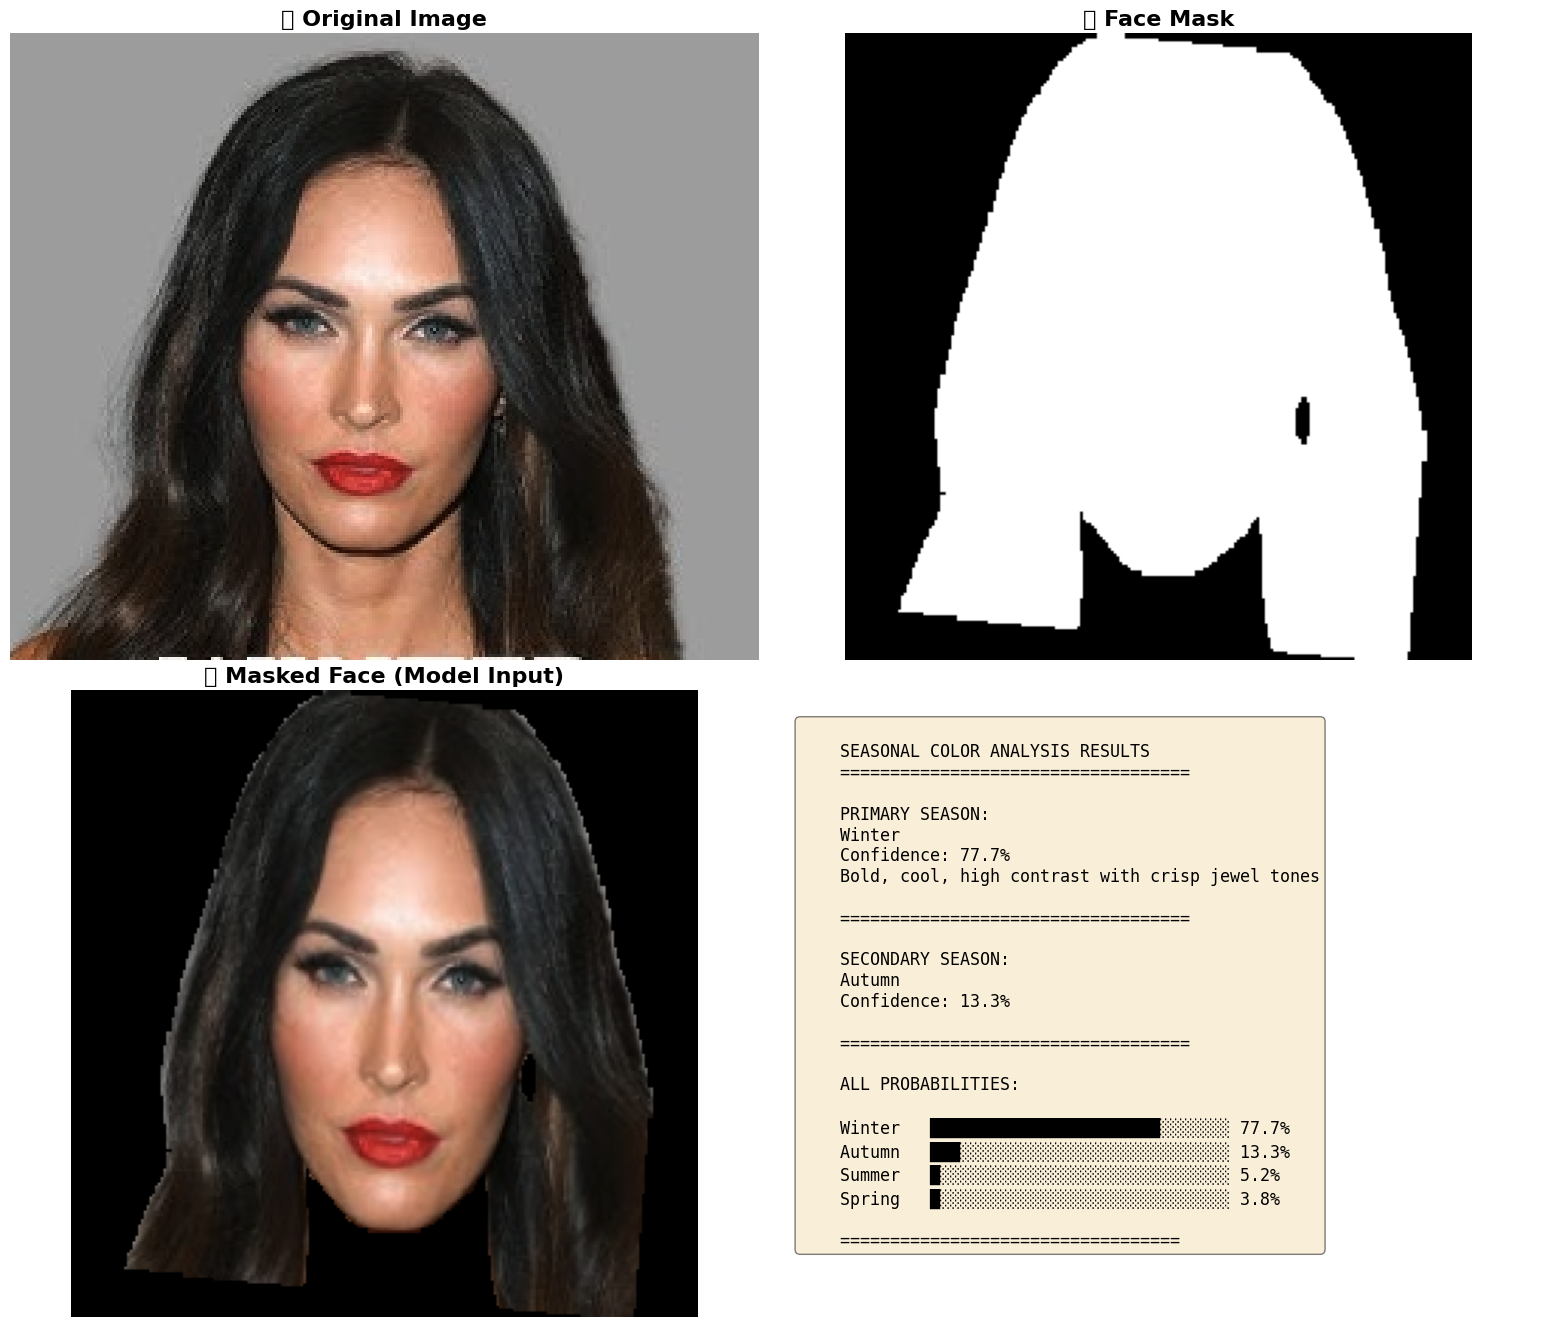

SEASONAL COLOR ANALYSIS RESULTS

 Primary Season: Winter (77.7%)
 Secondary Season: Autumn (13.3%)

 All Probabilities:
   Winter  : 77.7%
   Autumn  : 13.3%
   Summer  : 5.2%
   Spring  : 3.8%


✅ Analysis complete!


In [15]:
# CELL 8: Main Testing Pipeline

print("SEASONAL COLOR ANALYSIS - TESTING")
print("="*60)
print("\n Please upload an image to analyze...")
print("   (Supported formats: JPG, PNG, JPEG)")
print("\n")

# Upload image
uploaded_images = files.upload()

if len(uploaded_images) == 0:
    print("No image uploaded! Please run this cell again.")
else:
    # Get the uploaded image
    image_name = list(uploaded_images.keys())[0]
    print(f"\n Image uploaded: {image_name}")

    # Save temporarily
    with open('temp_image.jpg', 'wb') as f:
        f.write(uploaded_images[image_name])

    print("\n" + "="*60)
    print("PROCESSING PIPELINE")
    print("="*60)

    # Step 1: Create face mask
    print("\n[1/3] Creating face mask...")
    masked_img, original_img, mask = create_face_crop_facer_style('temp_image.jpg')

    # Step 2: Run prediction
    print("\n[2/3] Running seasonal color prediction...")
    results = predict_season(masked_img)

    # Step 3: Display results
    print("\n[3/3] Displaying results...")
    display_results(original_img, masked_img, mask, results)

    print("\n✅ Analysis complete!")
    print("="*60)

DIAGNOSTIC: Visualizing All Detected Classes...

Running comprehensive class diagnostic...
   - Detecting faces...
   - Parsing faces...
   - Using model: farl/celebm/448
   - Found label_names attribute!

   - Face Parser Attributes:
     ['T_destination', 'add_module', 'apply', 'bfloat16', 'buffers', 'call_super_init', 'children', 'compile', 'conf_name', 'cpu', 'cuda', 'decode_image_to_cv2', 'device', 'double', 'dump_patches', 'eval', 'extra_repr', 'float', 'forward', 'forward_warped', 'get_buffer', 'get_extra_state', 'get_parameter', 'get_submodule', 'get_warp_grid', 'half', 'ipu', 'label_names', 'load_state_dict', 'logits2predictions', 'modules', 'mtia', 'named_buffers', 'named_children', 'named_modules', 'named_parameters', 'net', 'parameters', 'register_backward_hook', 'register_buffer', 'register_forward_hook', 'register_forward_pre_hook', 'register_full_backward_hook', 'register_full_backward_pre_hook', 'register_load_state_dict_post_hook', 'register_load_state_dict_pre_hook', 

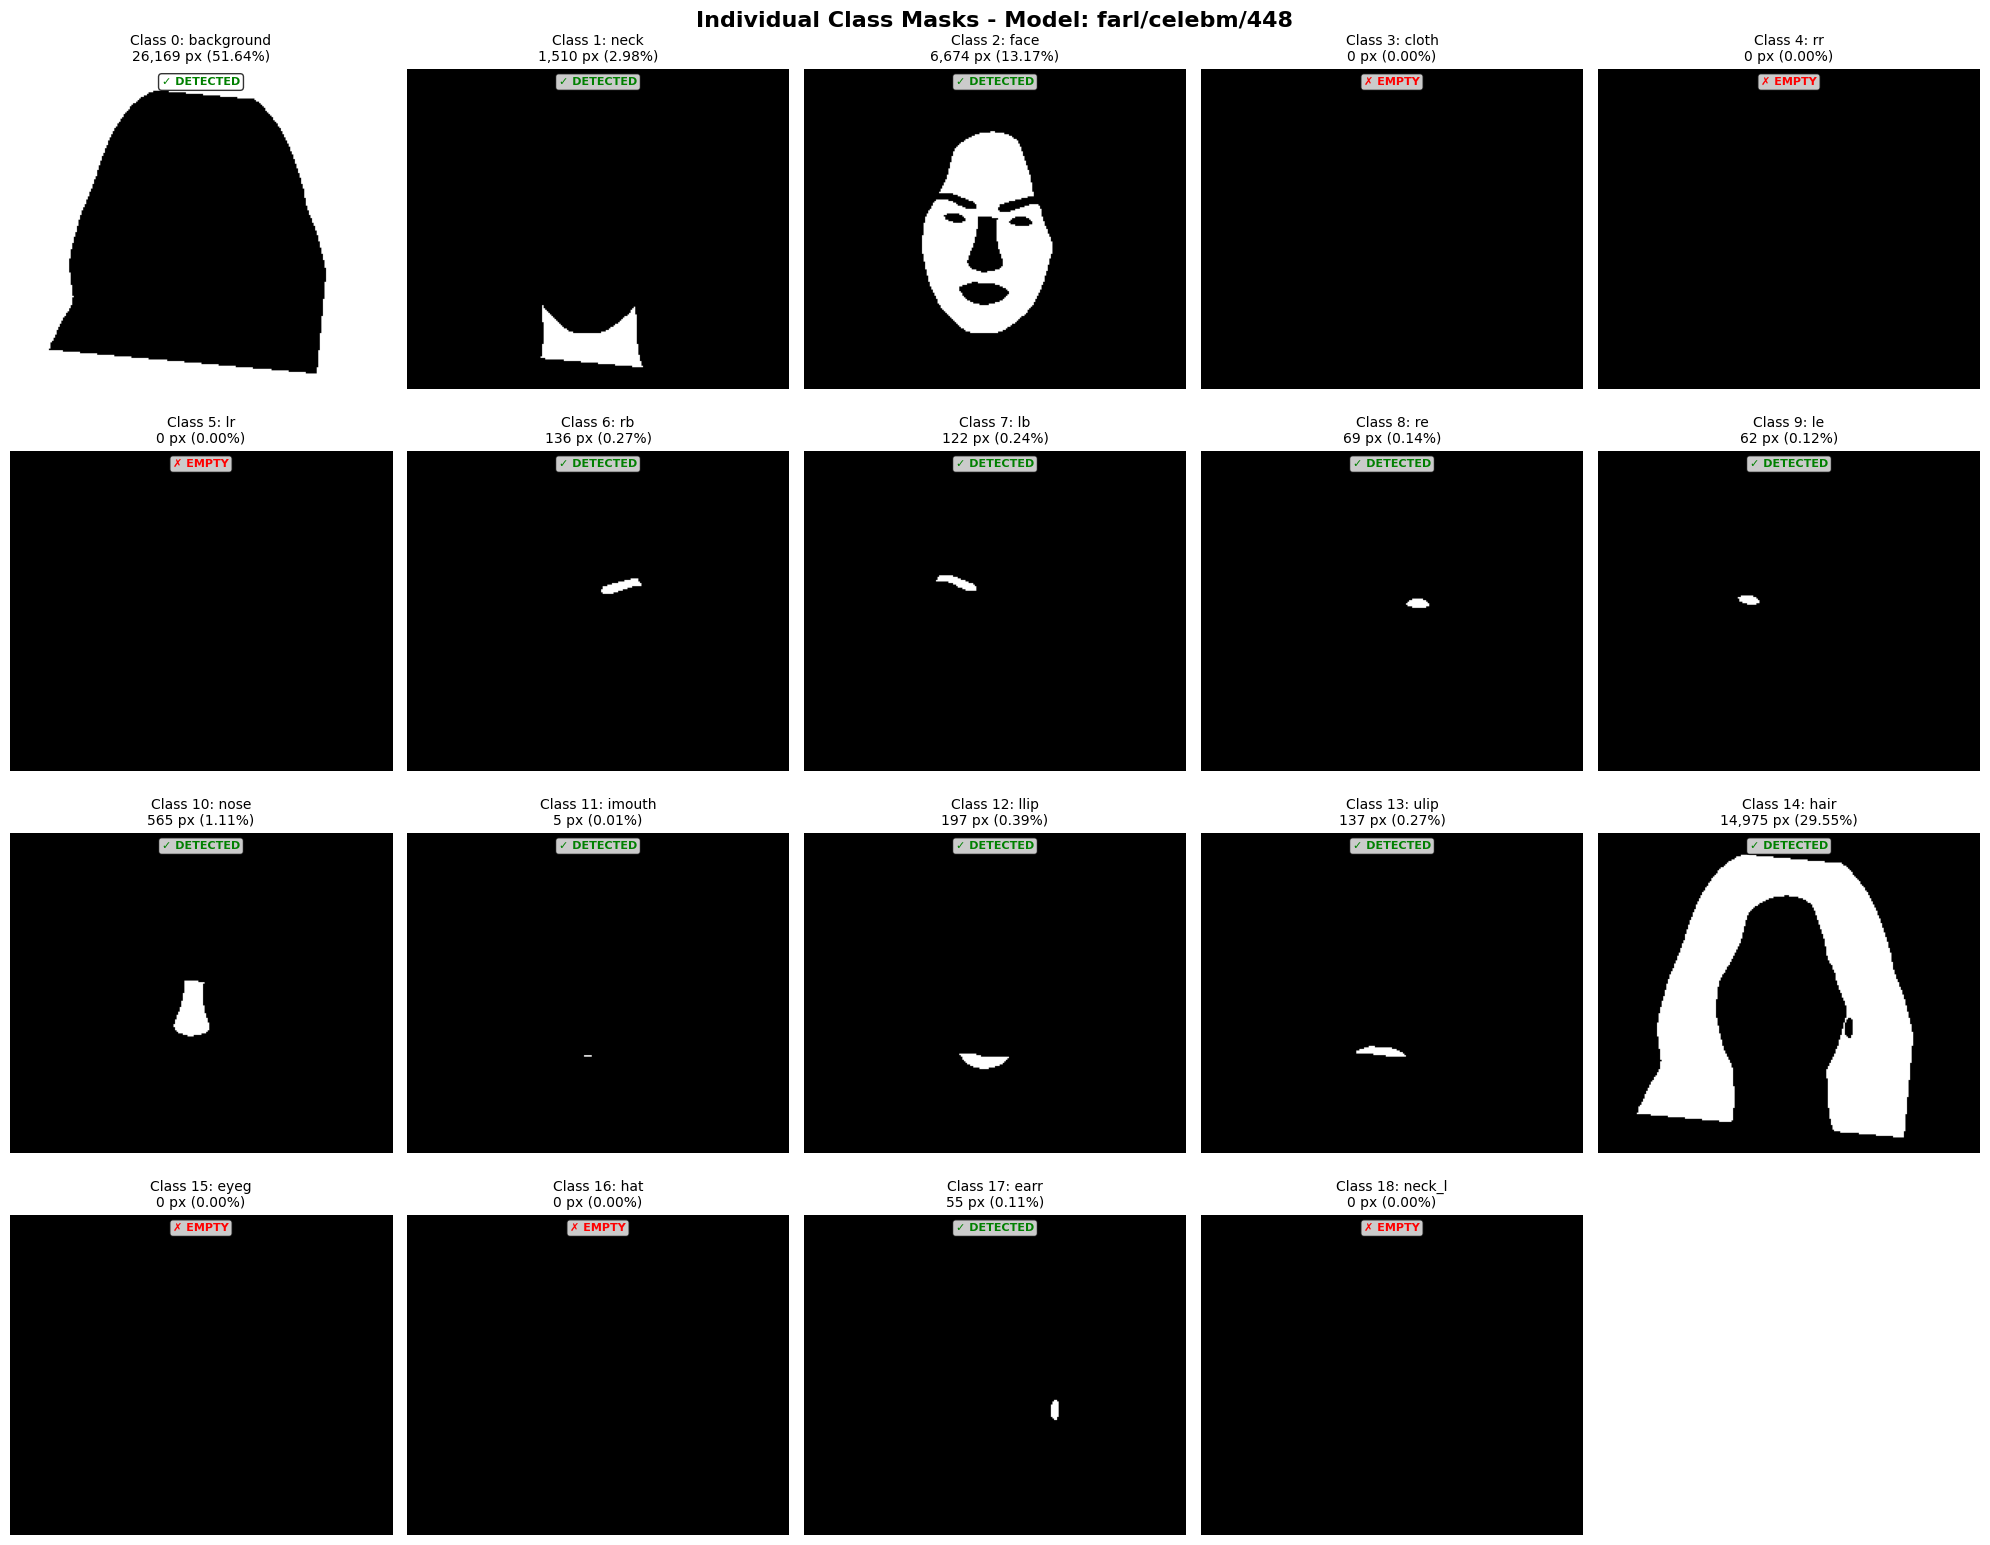


SHOWING ORIGINAL + All Detected Classes Combined...



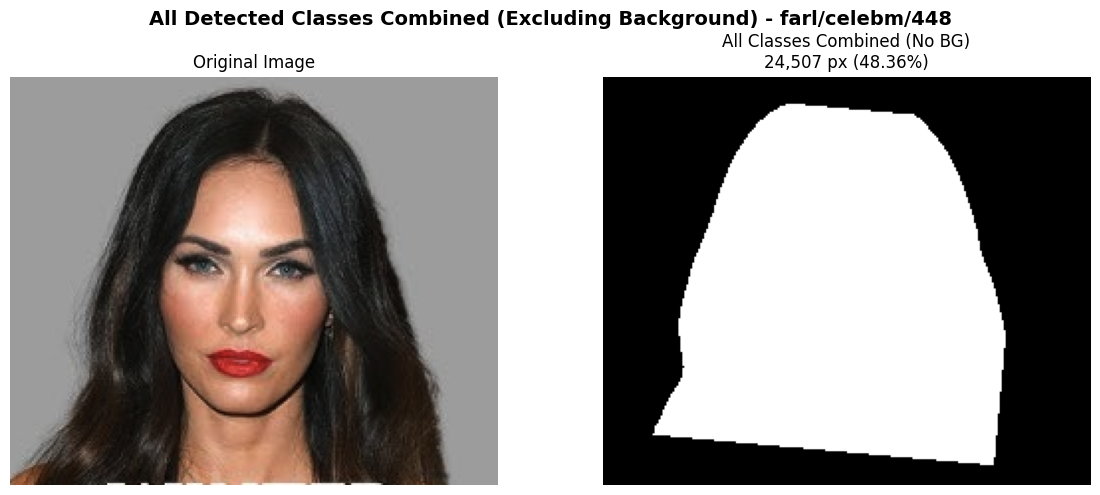


Diagnostic complete!



In [16]:
print("DIAGNOSTIC: Visualizing All Detected Classes...")


def diagnose_individual_classes_all(image_path):
    """Visualize each class from 0 to n_classes-1 separately with automatic label detection"""
    import facer
    import matplotlib.pyplot as plt
    import math
    import torch
    import cv2
    import numpy as np


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


    # Read and prepare
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_tensor = torch.tensor(image_rgb, dtype=torch.uint8).permute(2, 0, 1).unsqueeze(0).to(device)


    # Detect faces
    print("   - Detecting faces...")
    face_detector = facer.face_detector('retinaface/mobilenet', device=device)
    faces = face_detector(image_tensor)
    if not faces or len(faces) == 0:
        print("    No faces detected!")
        return


    # Parse faces - Try CelebAMask-HQ first, fallback to LaPa
    print("   - Parsing faces...")
    model_name = None
    try:
        model_name = 'farl/celebm/448'
        face_parser = facer.face_parser(model_name, device=device)
        print(f"   - Using model: {model_name}")
    except:
        model_name = 'farl/lapa/448'
        face_parser = facer.face_parser(model_name, device=device)
        print(f"   - Using model: {model_name}")


    # Try to get labels automatically from the model
    class_names = None

    # Method 1: Check for labels attribute (like face_attr has)
    if hasattr(face_parser, 'labels'):
        print("   - Found labels attribute in model!")
        class_names = {i: label for i, label in enumerate(face_parser.labels)}

    # Method 2: Check model's internal attributes
    elif hasattr(face_parser, 'model') and hasattr(face_parser.model, 'labels'):
        print("   - Found labels in model.labels!")
        class_names = {i: label for i, label in enumerate(face_parser.model.labels)}

    # Method 3: Check for label_names or class_names attributes
    elif hasattr(face_parser, 'label_names'):
        print("   - Found label_names attribute!")
        class_names = {i: label for i, label in enumerate(face_parser.label_names)}
    elif hasattr(face_parser, 'class_names'):
        print("   - Found class_names attribute!")
        class_names = {i: label for i, label in enumerate(face_parser.class_names)}

    # Fallback: Use hardcoded labels based on model name
    else:
        print("   - No automatic labels found, using hardcoded mapping...")
        if 'celebm' in model_name.lower():
            # CelebAMask-HQ official class order
            class_names = {
                0: "Background",
                1: "Skin",
                2: "Nose",
                3: "Eye Glasses",
                4: "Left Eye",
                5: "Right Eye",
                6: "Left Eyebrow",
                7: "Right Eyebrow",
                8: "Left Ear",
                9: "Right Ear",
                10: "Mouth",
                11: "Upper Lip",
                12: "Lower Lip",
                13: "Hair",
                14: "Hat",
                15: "Earring",
                16: "Necklace",
                17: "Neck",
                18: "Cloth"
            }
        elif 'lapa' in model_name.lower():
            # LaPa official class order
            class_names = {
                0: "Background",
                1: "Face Skin",
                2: "Left Eyebrow",
                3: "Right Eyebrow",
                4: "Left Eye",
                5: "Right Eye",
                6: "Nose",
                7: "Upper Lip",
                8: "Lower Lip",
                9: "Inner Mouth",
                10: "Hair"
            }
        else:
            class_names = {}


    # Debug: Print all available attributes of face_parser
    print("\n   - Face Parser Attributes:")
    parser_attrs = [attr for attr in dir(face_parser) if not attr.startswith('_')]
    print(f"     {parser_attrs}")


    faces = face_parser(image_tensor, faces)
    if isinstance(faces, list):
        faces = faces[0]


    seg_logits = faces['seg']['logits']
    seg_probs  = seg_logits.softmax(dim=1)
    seg_pred   = seg_probs.argmax(dim=1)[0].cpu().numpy()
    n_classes  = seg_probs.shape[1]
    totals     = seg_pred.size


    print(f"\nTOTAL CLASSES: {n_classes}")
    print(f"DICTIONARY HAS: {len(class_names)} class names\n")


    # Verify class_names covers all classes
    if len(class_names) != n_classes:
        print(f"⚠️  WARNING: Mismatch! Model has {n_classes} classes but dictionary has {len(class_names)}!")
        print(f"   Filling missing classes with generic names...\n")
        for i in range(n_classes):
            if i not in class_names:
                class_names[i] = f"Class_{i}"


    # Print stats for all classes
    print("=" * 70)
    print("INDIVIDUAL CLASS ANALYSIS (All Detected Classes)")
    print("=" * 70)


    masks_individual = {}
    for cls in range(n_classes):
        mask = (seg_pred == cls).astype(np.uint8) * 255
        masks_individual[cls] = mask
        cnt = int(np.sum(seg_pred == cls))
        pct = 100.0 * cnt / totals
        name = class_names.get(cls, f"Unknown_Class_{cls}")
        status = "✓ DETECTED" if cnt > 0 else "✗ EMPTY"
        print(f"Class {cls:2d} | {name:20s} | {cnt:7d} px ({pct:5.2f}%) | {status}")


    # Visualize all classes in a grid
    print(f"\nVISUALIZING ALL {n_classes} CLASSES...\n")


    # Calculate grid size (approximate square layout)
    grid_cols = math.ceil(math.sqrt(n_classes))
    grid_rows = math.ceil(n_classes / grid_cols)


    fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(grid_cols * 4, grid_rows * 4))
    fig.suptitle(f'Individual Class Masks - Model: {model_name}', fontsize=16, fontweight='bold')


    # Handle both single axis and multiple axes cases
    if n_classes == 1:
        axes = [axes]
    else:
        axes = axes.flatten()


    for idx in range(n_classes):
        cls = idx
        mask = masks_individual[cls]
        cnt = int(np.sum(seg_pred == cls))
        pct = 100.0 * cnt / totals
        name = class_names.get(cls, f"Class_{cls}")


        axes[idx].imshow(mask, cmap='gray')
        axes[idx].set_title(f'Class {cls}: {name}\n{cnt:,} px ({pct:.2f}%)', fontsize=10)
        axes[idx].axis('off')


        # Add status indicator
        if cnt > 0:
            axes[idx].text(0.5, 0.95, '✓ DETECTED',
                          transform=axes[idx].transAxes,
                          ha='center', fontsize=8, color='green', fontweight='bold',
                          bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        else:
            axes[idx].text(0.5, 0.95, '✗ EMPTY',
                          transform=axes[idx].transAxes,
                          ha='center', fontsize=8, color='red', fontweight='bold',
                          bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))


    # Turn off unused subplots
    for i in range(n_classes, len(axes)):
        fig.delaxes(axes[i])


    plt.tight_layout()
    plt.show()


    # Show Original + All Combined
    print("\nSHOWING ORIGINAL + All Detected Classes Combined...\n")


    # Combine all detected classes (excluding background)
    combined_all_classes = np.zeros_like(seg_pred, dtype=np.uint8)
    for cls in range(1, n_classes):  # Start from 1 to exclude background
        combined_all_classes[seg_pred == cls] = 255


    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(f'All Detected Classes Combined (Excluding Background) - {model_name}',
                 fontsize=14, fontweight='bold')


    axes[0].imshow(image_rgb)
    axes[0].set_title('Original Image')
    axes[0].axis('off')


    axes[1].imshow(combined_all_classes, cmap='gray')
    cnt_combined = int(np.sum(combined_all_classes > 0))
    pct_combined = 100.0 * cnt_combined / totals
    axes[1].set_title(f'All Classes Combined (No BG)\n{cnt_combined:,} px ({pct_combined:.2f}%)')
    axes[1].axis('off')


    plt.tight_layout()
    plt.show()

    print("\nDiagnostic complete!\n")


print("\nRunning comprehensive class diagnostic...")
result = diagnose_individual_classes_all('temp_image.jpg')